### Początkowe importy

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

### Wstępne przygotowanie danych

In [3]:
df = pd.read_csv('NoFluffJobs.csv')

In [4]:
df.columns

Index(['Unnamed: 0', 'Url', 'Offer_title', 'Company', 'Category', 'Seniority',
       'location', 'Musts', 'Nices', 'Reqirements', 'Descroption',
       'Daily_tasks', 'Offer_details', 'Salary_min', 'Salary_max', 'Currency'],
      dtype='object')

In [5]:
# Usuwam kolumnę Unnamed
offers = df.drop(df.columns[0], axis = 1)
offers.columns

Index(['Url', 'Offer_title', 'Company', 'Category', 'Seniority', 'location',
       'Musts', 'Nices', 'Reqirements', 'Descroption', 'Daily_tasks',
       'Offer_details', 'Salary_min', 'Salary_max', 'Currency'],
      dtype='object')

In [6]:
offers.shape

(3315, 15)

In [7]:
offers.dtypes

Url               object
Offer_title       object
Company           object
Category          object
Seniority         object
location          object
Musts             object
Nices             object
Reqirements       object
Descroption       object
Daily_tasks       object
Offer_details     object
Salary_min        object
Salary_max       float64
Currency          object
dtype: object

In [8]:
offers["Salary_min"][26]

'4653  PLN  brutto miesięcznie (UZ)'

In [9]:
# Usuwam zbędne znaki z kolumn Salary_min i Category
offers["Salary_min"] = offers["Salary_min"].apply(lambda x: re.search(r'(\d+(\.\d+)?)', str(x)).group(1) if re.search(r'(\d+(\.\d+)?)', str(x)) else None)
offers["Category"] = offers["Category"].str.replace('\xa0', '')

# Po oczyszczeniu wierszy ze zbędnych znaków zmieniam typ "Salary_min" na float
offers = offers[offers["Salary_min"] != '']
offers["Salary_min"] = offers["Salary_min"].astype("float64")
offers.dtypes

Url               object
Offer_title       object
Company           object
Category          object
Seniority         object
location          object
Musts             object
Nices             object
Reqirements       object
Descroption       object
Daily_tasks       object
Offer_details     object
Salary_min       float64
Salary_max       float64
Currency          object
dtype: object

In [10]:
offers.describe()

,Salary_min,Salary_max
count,3019.000000,2987.000000
mean,17604.238490,23837.760295
std,7246.582466,9677.814179
min,11.000000,16.000000
25%,13000.000000,18000.000000
50%,17500.000000,24000.000000
75%,21840.000000,29000.000000
max,92250.000000,180811.000000


In [11]:
# Sprawdzam, czy są inne waluty niż PLN
offers['Currency'].value_counts()

PLN    3019
Name: Currency, dtype: int64

In [12]:
# Usuwam kolumnę "Currency" - nie ma innych niż "PLN"
offers.drop(columns=["Currency"], inplace=True)

In [13]:
# Poprawiam nazwy kolumn
offers.rename(columns = {'location':'Location', 'Descroption':'Description'}, inplace = True)

In [14]:
# Oferty bez minimalnej kwoty
offers["Salary_min"].isna().sum()

296

In [15]:
offers = offers.dropna(subset="Salary_min")

In [16]:
offers.isnull().sum()

Url                 0
Offer_title      1021
Company             0
Category            0
Seniority           0
Location         1405
Musts               0
Nices             930
Reqirements        60
Description       146
Daily_tasks       260
Offer_details       5
Salary_min          0
Salary_max         32
dtype: int64

In [17]:
# Podmieniam nulle w pozostałych kolumnach

offers["Offer_title"].fillna("No title", inplace=True)
offers["Location"].fillna("Many", inplace=True)
offers["Nices"].fillna("-", inplace=True)
offers["Reqirements"].fillna("-", inplace=True)
offers["Description"].fillna("-", inplace=True)
offers["Daily_tasks"].fillna("-", inplace=True)
offers["Offer_details"].fillna("-", inplace=True)
offers["Salary_max"].fillna(offers["Salary_min"], inplace=True)

In [18]:
# tworzę nową kolumnę ze średnim wynagrodzeniem (na podstawie podanych widełek)
offers['Salary_average'] = offers[['Salary_min', 'Salary_max']].mean(axis=1)

### Wykresy

In [19]:
offers["Seniority"].value_counts()

Senior     1414
Mid        1213
Junior      317
Expert       62
Trainee      13
Name: Seniority, dtype: int64

In [20]:
offers["Company"].value_counts()

Sii Polska             131
Link Group             106
emagine Sp. Z o.o.      83
Elitmind                67
AVENGA                  60
                      ... 
Capco Poland             1
Billigence               1
MetaGravity              1
Staffbit                 1
Macrobond Financial      1
Name: Company, Length: 497, dtype: int64

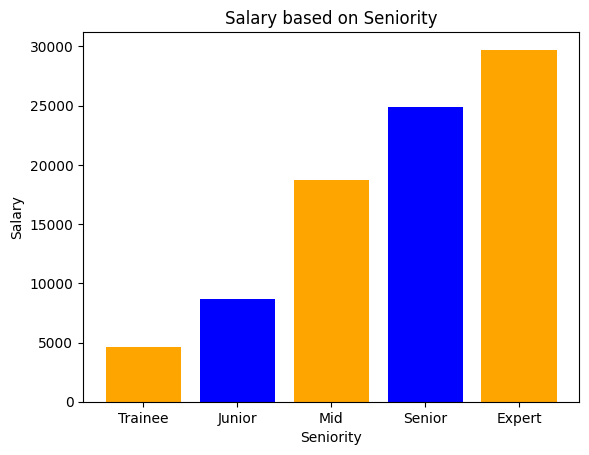

In [21]:
custom_order = ['Trainee', 'Junior', 'Mid', 'Senior', 'Expert']
av_salary_by_seniority = offers.groupby('Seniority')['Salary_average'].mean()
av_salary_by_seniority_sorted = av_salary_by_seniority.reindex(custom_order)

fig, ax = plt.subplots()
ax.bar(av_salary_by_seniority_sorted.index, av_salary_by_seniority_sorted.values, color=['orange', 'blue'])
ax.set_title('Salary based on Seniority')
ax.set_xlabel('Seniority')
ax.set_ylabel('Salary')

plt.show()

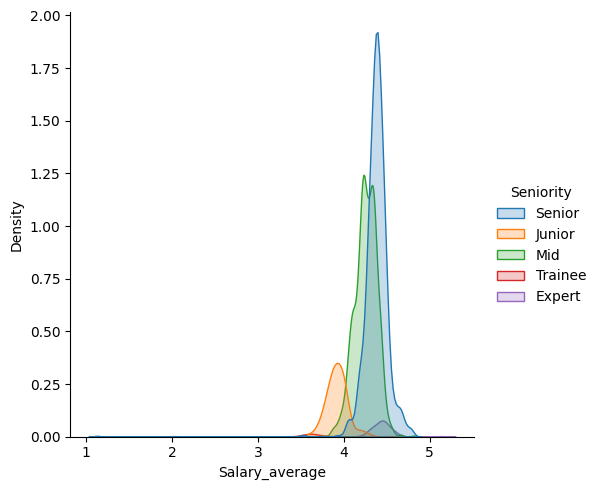

In [22]:
# offers['Salary_average_log10'] = np.log10(offers['Salary_average'])
salary_seniority = sns.displot(data=offers, x=(np.log10(offers['Salary_average'])), hue='Seniority', kind='kde', fill=True)

In [23]:
top_categories = offers['Category'].value_counts().nlargest(10).index
filtered_offers = offers[offers['Category'].isin(top_categories)]

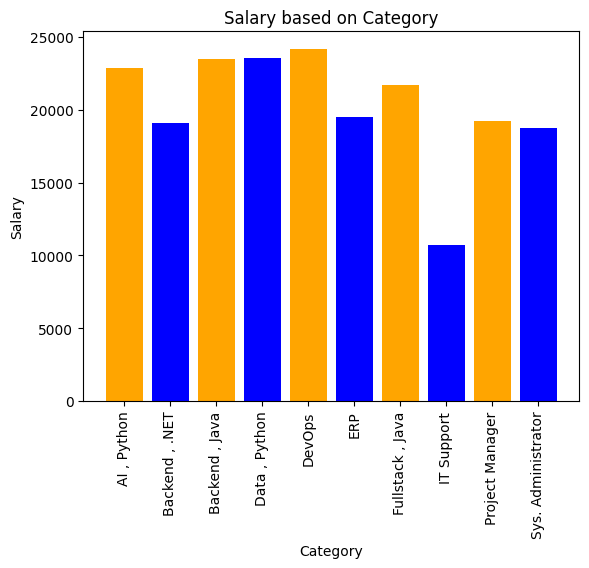

In [24]:
av_salary_by_category = filtered_offers.groupby('Category')['Salary_average'].mean()
av_salary_by_category_sorted = av_salary_by_category.sort_index()

fig, ax = plt.subplots()
ax.bar(av_salary_by_category_sorted.index, av_salary_by_category_sorted.values, color=['orange', 'blue'])
ax.set_title('Salary based on Category')
ax.set_xlabel('Category')
ax.set_ylabel('Salary')
ax.xaxis.set_tick_params(rotation=90)

plt.show()

In [25]:
top_companies = offers['Company'].value_counts().nlargest(10).index
filtered_offers = offers[offers['Company'].isin(top_companies)]

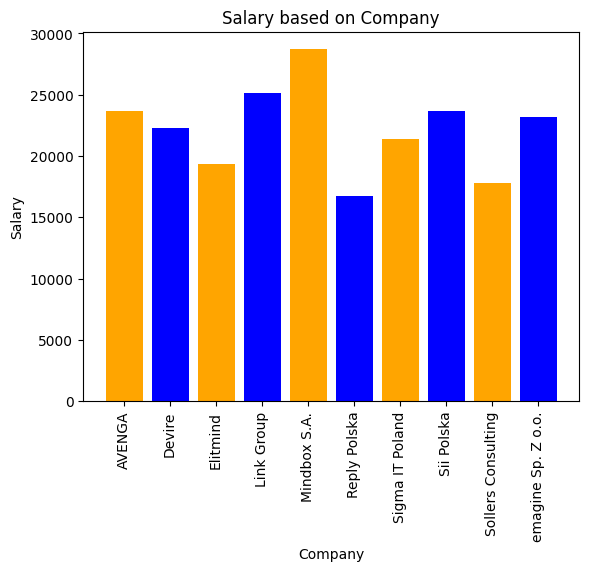

In [26]:
av_salary_by_company = filtered_offers.groupby('Company')['Salary_average'].mean()

fig, ax = plt.subplots()

ax.bar(av_salary_by_company.index, av_salary_by_company.values, color=['orange', 'blue'])
ax.set_title('Salary based on Company')
ax.set_xlabel('Company')
ax.set_ylabel('Salary')
ax.xaxis.set_tick_params(rotation=90)

plt.show()

#### Porównanie kształtowania się wynagrodzenia (śrenie, minimalne, maksymalne)

<Axes: >

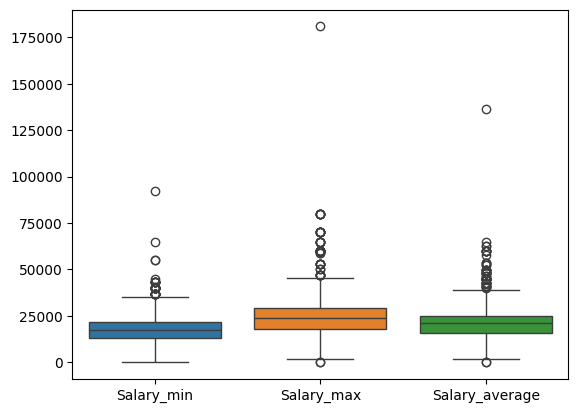

In [27]:
sns.boxplot(offers)

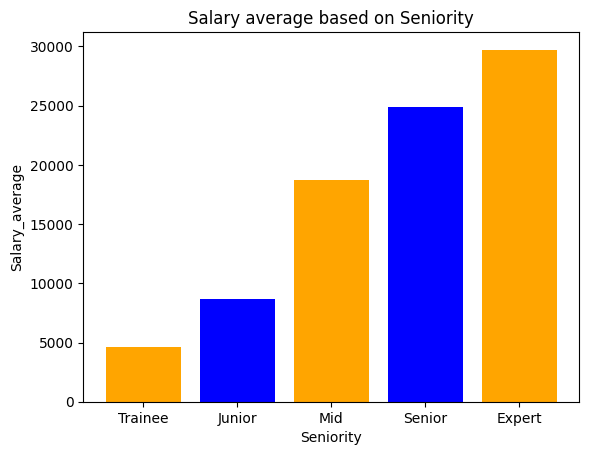

In [28]:
av_salary_by_seniority = offers.groupby('Seniority')['Salary_average'].mean()
av_salary_by_seniority_sorted = av_salary_by_seniority.reindex(custom_order)

fig, ax = plt.subplots()

ax.bar(av_salary_by_seniority_sorted.index, av_salary_by_seniority_sorted.values, color=['orange', 'blue'])
ax.set_title('Salary average based on Seniority')
ax.set_xlabel('Seniority')
ax.set_ylabel('Salary_average')

plt.show()

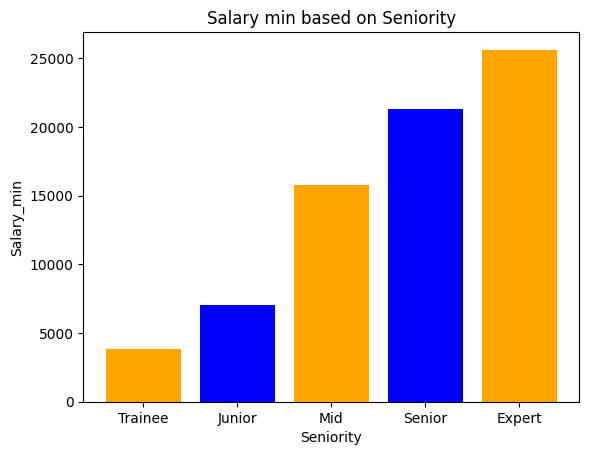

In [29]:
custom_order = ['Trainee', 'Junior', 'Mid', 'Senior', 'Expert']
av_salary_by_seniority = offers.groupby('Seniority')['Salary_min'].mean()
av_salary_by_seniority_sorted = av_salary_by_seniority.reindex(custom_order)

fig, ax = plt.subplots()

ax.bar(av_salary_by_seniority_sorted.index, av_salary_by_seniority_sorted.values, color=['orange', 'blue'])
ax.set_title('Salary min based on Seniority')
ax.set_xlabel('Seniority')
ax.set_ylabel('Salary_min')

plt.show()

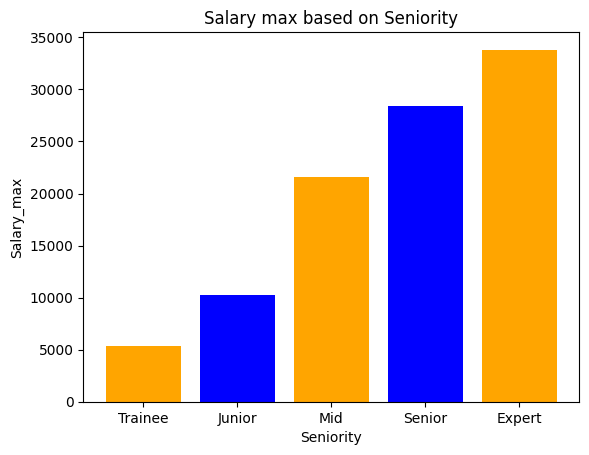

In [30]:
custom_order = ['Trainee', 'Junior', 'Mid', 'Senior', 'Expert']
av_salary_by_seniority = offers.groupby('Seniority')['Salary_max'].mean()
av_salary_by_seniority_sorted = av_salary_by_seniority.reindex(custom_order)

fig, ax = plt.subplots()

ax.bar(av_salary_by_seniority_sorted.index, av_salary_by_seniority_sorted.values, color=['orange', 'blue'])
ax.set_title('Salary max based on Seniority')
ax.set_xlabel('Seniority')
ax.set_ylabel('Salary_max')

plt.show()

### Podział na zbiory

In [36]:
offers["Seniority"].value_counts()

Senior     1414
Mid        1213
Junior      317
Expert       62
Trainee      13
Name: Seniority, dtype: int64

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit

In [40]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(offers, offers["Seniority"]):
  strat_train_set = offers.iloc[train_index]
  strat_test_set = offers.iloc[test_index]

In [41]:
X_train = strat_train_set[['Seniority', 'Company']]
X_test = strat_test_set[['Seniority', 'Company']]

y_train = strat_train_set[['Salary_average']]
y_test = strat_test_set[['Salary_average']]

### OHE

In [42]:
ohe = OneHotEncoder(min_frequency=0.02, handle_unknown='ignore')

In [43]:
ohe.fit(offers[['Seniority', 'Company']])

OneHotEncoder(handle_unknown='ignore', min_frequency=0.02)

In [44]:
categorical_ohe = ohe.transform(offers[['Seniority', 'Company']])

In [45]:
ohe.get_feature_names_out()

array(['Seniority_Expert', 'Seniority_Junior', 'Seniority_Mid',
       'Seniority_Senior', 'Seniority_infrequent_sklearn',
       'Company_Elitmind', 'Company_Link Group', 'Company_Sii Polska',
       'Company_emagine Sp. Z o.o.', 'Company_infrequent_sklearn'],
      dtype=object)

In [46]:
categorical_features = ['Seniority', 'Company']
ct = ColumnTransformer(transformers = [('ohe', ohe, categorical_features)])

In [47]:
X_train_processed = ct.fit_transform(X_train)

### Regresja liniowa

In [48]:
lr = LinearRegression()
lr.fit(X_train_processed, y_train)

LinearRegression()

In [49]:
lr.score(X_train_processed, y_train)

0.40419217319254974

In [50]:
from sklearn.metrics import mean_squared_error
salary_predictions = lr.predict(X_train_processed)
lr_mse = mean_squared_error(y_train, salary_predictions)
lr_mse

41512664.679259725

In [51]:
lr_rmse = np.sqrt(lr_mse)
lr_rmse

6443.032258126582

In [ ]:
# Regularyzacja L1
from sklearn import linear_model

params = {'alpha': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
lasso = linear_model.Lasso()

# GridSearch
gs_lasso = GridSearchCV(estimator=lasso,
                        param_grid=params,
                        scoring='neg_mean_absolute_error',
                        cv=10,
                        return_train_score=True,
                        verbose=3)

gs_lasso.fit(X_train_processed,y_train)

In [54]:
gs_lasso.best_params_

{'alpha': 2.0}

In [56]:
gs_lasso.best_score_

-4292.221792560295

In [57]:
lasso = linear_model.Lasso(alpha = 2.0)
lasso.fit(X_train_processed,y_train)

Lasso(alpha=2.0)

In [58]:
lasso.score(X_train_processed, y_train)

0.40416995949547263

In [59]:
salary_predictions = lasso.predict(X_train_processed)
lasso_mse = mean_squared_error(y_train, salary_predictions)
lasso_mse

41514212.409444794

In [60]:
lasso_rmse = np.sqrt(lasso_mse)
lasso_rmse

6443.15236584118

In [ ]:
# Regularyzacja L2

ridge = linear_model.Ridge()

# GridSearch
gs_ridge = GridSearchCV(estimator=ridge,
                       param_grid=params,
                       scoring='neg_mean_absolute_error',
                       cv=10,
                       return_train_score=True,
                       verbose=3)

gs_ridge.fit(X_train_processed,y_train)

In [62]:
gs_ridge.best_params_

{'alpha': 0.3}

In [64]:
gs_ridge.best_score_

-4292.402682353714

In [65]:
ridge = linear_model.Ridge(alpha=0.3)
ridge.fit(X_train_processed,y_train)

Ridge(alpha=0.3)

In [66]:
ridge.score(X_train_processed, y_train)

0.404182390225463

In [96]:
X_test_processed = ct.transform(X_test)
lr.score(X_test_processed, y_test)

0.42725025859216503

### Drzewo decyzyjne

In [68]:
tree = DecisionTreeRegressor(max_depth=5,
                             min_samples_leaf=10,
                             min_samples_split=15)
tree.fit(X_train_processed, y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=15)

In [69]:
tree.score(X_train_processed, y_train)

0.408453959571236

In [70]:
salary_predictions = tree.predict(X_train_processed)
tree_mse = mean_squared_error(y_train, salary_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

6419.947544215098

In [97]:
X_test_processed = ct.transform(X_test)
tree.score(X_test_processed, y_test)

0.43298046846388527

In [ ]:
from sklearn.metrics import get_scorer_names
all_scorers = get_scorer_names()
all_scorers

In [74]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree, X_train_processed, y_train,
scoring="neg_mean_squared_error", cv=15)
tree_rmse_scores = np.sqrt(-scores)

In [75]:
# scores_2 = cross_val_score(tree, X_train_processed, y_train,
# scoring="r2", cv=15)
# tree_r2_scores = scores_2

In [78]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 5436.33172566  6105.96341704  5918.62904444  5980.54949965
  5372.4103979   6353.07071603  5799.23455747  6355.32422813
 10716.65194248  6476.27179568  6679.02850308  6718.86874967
  6149.85426938  7789.7891679   4841.51733368]
Mean: 6446.233023212283
Standard deviation: 1317.9164561426405


### Decision tree + GridSearch

In [79]:
dtree = DecisionTreeRegressor()

params = {'max_depth': [3, 7, 15],
          'min_samples_split': [10, 20, 30]}

In [80]:
gs = GridSearchCV(dtree,
                  param_grid = params,
                  cv = 15, scoring='neg_mean_squared_error',
                  verbose = 3)

In [ ]:
gs.fit(X_train_processed, y_train)

In [82]:
gs.best_estimator_

DecisionTreeRegressor(max_depth=7, min_samples_split=10)

In [83]:
gs.best_score_

-41808604.12521641

In [84]:
gs.best_params_

{'max_depth': 7, 'min_samples_split': 10}

In [89]:
cvres = gs.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

6511.364605160354 {'max_depth': 3, 'min_samples_split': 10}
6511.551539824978 {'max_depth': 3, 'min_samples_split': 20}
6511.551539824978 {'max_depth': 3, 'min_samples_split': 30}
6465.9573247289845 {'max_depth': 7, 'min_samples_split': 10}
6466.145572106956 {'max_depth': 7, 'min_samples_split': 20}
6466.145572106956 {'max_depth': 7, 'min_samples_split': 30}
6466.005096070225 {'max_depth': 15, 'min_samples_split': 10}
6466.19334205745 {'max_depth': 15, 'min_samples_split': 20}
6466.19334205745 {'max_depth': 15, 'min_samples_split': 30}


In [ ]:
# X_test_processed = ct.transform(X_test)

In [ ]:
# gs.score(X_test_processed, y_test)

### Random Forest

In [85]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(max_depth=15,
                               min_samples_split=20)
forest.fit(X_train_processed, y_train)

<ipython-input-85-31ccdd209c5e>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train_processed, y_train)


RandomForestRegressor(max_depth=15, min_samples_split=20)

In [86]:
forest.score(X_train_processed, y_train)

0.409713425400562

In [87]:
salary_predictions = forest.predict(X_train_processed)
forest_mse = mean_squared_error(y_train, salary_predictions)
forest_rmse = np.sqrt(tree_mse)
forest_rmse

6419.947544215098

In [98]:
X_test_processed = ct.transform(X_test)
forest.score(X_test_processed, y_test)

0.42676151584152944

### Model

In [91]:
!pip install joblib

In [92]:
import joblib
joblib.dump(forest, "my_model.pkl")

my_model_loaded = joblib.load("my_model.pkl")